# End-to-End Classification project

##  Problem Statement

The goal of this project is to build and analyze an end-to-end classification system using handwritten digit images, with a specific focus on understanding and distinguishing between **multiclass**, **multilabel**, and **multioutput** classification problems.

Each data sample represents a single handwritten digit image from the MNIST dataset, flattened into a vector of pixel intensities. Using the same input features, the project explores three progressively more realistic prediction settings:

1. **Multiclass Classification**  
   In the first setting, the task is to predict the digit value (0–9).  
   Each image belongs to exactly one class, making this a standard multiclass classification problem where classes are mutually exclusive and the final prediction is obtained using an argmax decision rule.

2. **Multilabel Classification**  
   In the second setting, the problem is reformulated to predict multiple independent properties of each digit.  
   Each image may satisfy more than one property simultaneously, such as being even, prime, or large.  
   This setting requires treating each label as an independent binary classification task, using threshold-based decisions rather than argmax, and evaluating performance using multilabel-specific metrics.

3. **Multioutput Classification**  
   In the final setting, the model is required to predict multiple outputs with different semantic meanings.  
   Specifically, the task is to predict both the digit value (a multiclass output) and a binary property of the digit.  
   This setting highlights the distinction between multilabel classification and multioutput classification, where outputs are not simply multiple labels of the same type.

The primary objective of this project is not to maximize predictive performance, but to develop a clear conceptual understanding of:
- when multiclass formulations are sufficient,
- when multilabel formulations are necessary,
- how decision rules and evaluation metrics differ across problem types, and
- how the same input data can lead to fundamentally different modeling approaches depending on the target structure.

This project follows a Géron-style, intuition-first approach and emphasizes correct problem formulation, label-wise reasoning, and appropriate evaluation over model complexity.


### Import Libararies

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, hamming_loss
from sklearn.multioutput import MultiOutputClassifier

### Load Dataset

In [2]:
mnist = fetch_openml('mnist_784', version = 1, as_frame=False)

C:\Users\ayush\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [12]:
X, y = mnist['data'], mnist['target']
X = X.astype("float32")
y = y.astype("int")

### Label Construction

In [13]:
y_digit = y

y_props = np.c_[
    (y % 2 == 0), #is_even
    (y % 2 == 1), #is_odd
    np.isin(y,[2,3,5,7]),#is_prime
    (y >= 5)
].astype(int)

In [14]:
y_props

array([[0, 1, 1, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [1, 0, 0, 0],
       [0, 1, 1, 1],
       [1, 0, 0, 1]])

## Split into train and test

In [19]:
X_train, X_test, \
y_digit_train, y_digit_test, \
y_props_train, y_props_test = train_test_split(X, y_digit, y_props, test_size = 0.2, random_state = 42)

## Create a Pipeline for 
1. Scaling
2. Fitting the model

In [40]:
pipeline_mlt_class = Pipeline([
    ("scaler", StandardScaler()),
    ("log_reg_clf", LogisticRegression(max_iter = 1000))
])

In [41]:
pipeline_mlt_class.fit(X_train, y_digit_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg_clf', LogisticRegression(max_iter=1000))])

In [53]:
y_pred = pipeline_mlt_class.predict(X_test)
y_pred

array([8, 4, 5, ..., 2, 7, 1])

## Error Analysis

In [54]:
cm  = confusion_matrix(y_digit_test, y_pred)
cm

array([[1286,    1,   11,    0,    1,   11,   21,    4,    6,    2],
       [   0, 1556,    7,   10,    3,    6,    1,    4,   11,    2],
       [   6,   19, 1233,   18,   13,   13,   20,   18,   29,   11],
       [   7,    9,   37, 1272,    1,   39,    7,   22,   19,   20],
       [   5,    2,   11,    4, 1189,    5,   12,    9,    9,   49],
       [  12,    9,   10,   42,   12, 1114,   20,    2,   36,   16],
       [   7,    5,   18,    1,   17,   21, 1319,    3,    5,    0],
       [   4,    4,   22,    5,   13,    6,    0, 1415,    2,   32],
       [  11,   31,   16,   41,    5,   44,   13,    9, 1166,   21],
       [   6,    9,    6,   15,   36,    5,    0,   51,   12, 1280]],
      dtype=int64)

In [55]:
cm_norm = cm/cm.sum(axis=1, keepdims = True)
cm_norm

array([[9.57557707e-01, 7.44601638e-04, 8.19061802e-03, 0.00000000e+00,
        7.44601638e-04, 8.19061802e-03, 1.56366344e-02, 2.97840655e-03,
        4.46760983e-03, 1.48920328e-03],
       [0.00000000e+00, 9.72500000e-01, 4.37500000e-03, 6.25000000e-03,
        1.87500000e-03, 3.75000000e-03, 6.25000000e-04, 2.50000000e-03,
        6.87500000e-03, 1.25000000e-03],
       [4.34782609e-03, 1.37681159e-02, 8.93478261e-01, 1.30434783e-02,
        9.42028986e-03, 9.42028986e-03, 1.44927536e-02, 1.30434783e-02,
        2.10144928e-02, 7.97101449e-03],
       [4.88485694e-03, 6.28053036e-03, 2.58199581e-02, 8.87648290e-01,
        6.97836706e-04, 2.72156315e-02, 4.88485694e-03, 1.53524075e-02,
        1.32588974e-02, 1.39567341e-02],
       [3.86100386e-03, 1.54440154e-03, 8.49420849e-03, 3.08880309e-03,
        9.18146718e-01, 3.86100386e-03, 9.26640927e-03, 6.94980695e-03,
        6.94980695e-03, 3.78378378e-02],
       [9.42655145e-03, 7.06991359e-03, 7.85545954e-03, 3.29929301e-02,
   

In [56]:
np.fill_diagonal(cm_norm, 0)
cm_norm

array([[0.        , 0.0007446 , 0.00819062, 0.        , 0.0007446 ,
        0.00819062, 0.01563663, 0.00297841, 0.00446761, 0.0014892 ],
       [0.        , 0.        , 0.004375  , 0.00625   , 0.001875  ,
        0.00375   , 0.000625  , 0.0025    , 0.006875  , 0.00125   ],
       [0.00434783, 0.01376812, 0.        , 0.01304348, 0.00942029,
        0.00942029, 0.01449275, 0.01304348, 0.02101449, 0.00797101],
       [0.00488486, 0.00628053, 0.02581996, 0.        , 0.00069784,
        0.02721563, 0.00488486, 0.01535241, 0.0132589 , 0.01395673],
       [0.003861  , 0.0015444 , 0.00849421, 0.0030888 , 0.        ,
        0.003861  , 0.00926641, 0.00694981, 0.00694981, 0.03783784],
       [0.00942655, 0.00706991, 0.00785546, 0.03299293, 0.00942655,
        0.        , 0.01571092, 0.00157109, 0.02827965, 0.01256874],
       [0.00501433, 0.00358166, 0.01289398, 0.00071633, 0.01217765,
        0.01504298, 0.        , 0.002149  , 0.00358166, 0.        ],
       [0.00266134, 0.00266134, 0.0146373

## Visulaized the Normalized Confusion Matrix

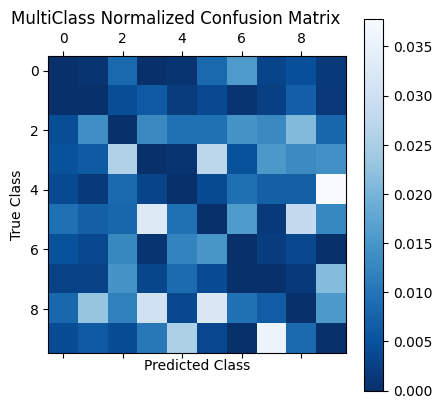

In [71]:
plt.matshow(cm_norm, cmap = plt.cm.Blues_r)
plt.colorbar()
plt.title("MultiClass Normalized Confusion Matrix ",loc = "right" )
plt.xlabel("Predicted Class")
plt.ylabel("True Class");

---
## Multiclass Classfication Error Analysis
---
**Most Confused Digit Pairs**
- 5 ↔ 3  
- 5 ↔ 8  
- 4 ↔ 9  
- 3 → 2  
- 8 → 3  

These confusions primarily occur between digits with similar stroke structures or symmetry patterns.

---
**Error Symmetry**
The majority of errors are symmetric, particularly between digit pairs such as 3 and 5, 5 and 8, and 4 and 9. This suggests that misclassifications arise from visual ambiguity in handwritten samples rather than systematic model bias toward a specific class.

---
**Class Difficulty**
Digit 8 appears to be consistently harder to classify compared to other digits. This is likely due to its complex structure and similarity to multiple other digits, making it more susceptible to confusion in ambiguous handwriting.

---

## Pipeline for MultiLabel

In [35]:
pipeline_mlt_lbl = Pipeline([
    ("scaler" , StandardScaler()),
    ("knn_clf", KNeighborsClassifier(n_neighbors=5))
])

pipeline_mlt_lbl.fit(X_train, y_props_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn_clf', KNeighborsClassifier())])

## Evaluation

In [83]:
y_prop_pred = pipeline_mlt_lbl.predict(X_test)

In [93]:
f1_macro = f1_score(y_props_test, y_prop_pred, average= "macro")
f1_weighted = f1_score(y_props_test, y_prop_pred, average = "weighted")
hamming = hamming_loss(y_props_test, y_prop_pred)
accuracy = accuracy_score(y_props_test, y_prop_pred)

In [94]:
print(f"F1 Score is (macro) : {f1_macro}")
print(f"F1 Score is (weighted) : {f1_weighted}")
print(f"Hamming Loss is : {hamming}")
print(f"Accuracy Score is : {accuracy}")

F1 Score is (macro) : 0.9686826072704466
F1 Score is (weighted) : 0.9691333192813473
Hamming Loss is : 0.029214285714285713
Accuracy Score is : 0.9452142857142857


---
## MultiLabel Classification Error Analysis
---
### What this tells

---
**Macro F1 ≈ Weighted F1**
* This is important.
* It means:
* Performance is fairly uniform across labels
* No single label is being ignored
* No extreme class imbalance effects

**If weighted F1 >> macro F1 → minority labels were suffering**
That is not happening here 

--- 

**Hamming Loss ≈ 0.029**
* Interpretation:
* On average, ~3% of individual label decisions are wrong
* That’s very good for multilabel.

   This confirms:
* Label-wise predictions are strong
* Even when exact match fails, most labels are still correct

---

**Accuracy ≈ 0.945 (Exact Match Ratio)**

* This metric is extremely strict
* One wrong label → whole sample counted wrong
* A value this high means:
* Your labels are relatively simple
* Model captures most properties jointly
---

**Performance Interpretation**

The multilabel classifier achieves high performance across all evaluation metrics. 
The close agreement between macro F1-score and weighted F1-score indicates that the model performs consistently across all labels, with no single label dominating the results.

The low Hamming loss (~0.03) shows that only a small fraction of individual label predictions are incorrect, confirming strong label-wise performance even when exact label combinations are not perfectly predicted.

Although the exact match ratio is lower than the F1-scores, this behavior is expected due to the strict nature of subset accuracy in multilabel settings. Overall, these results demonstrate that the multilabel formulation successfully captures independent digit properties more effectively than a single multiclass prediction.

---


## Pipeline for Multioutput

In [36]:
y_multioutput_train  = np.c_[
    y_digit_train,
    y_props_train[:,0]  #is_even
]

y_multioutput_test = np.c_[
    y_digit_test,
    y_props_test[:, 0]
]

In [43]:
pipeline_mlt_output = Pipeline([
    ("scaler" , StandardScaler()),
    ("clfs", MultiOutputClassifier(LogisticRegression(max_iter =1000)
                                  ))
])

In [44]:
pipeline_mlt_output.fit(X_train, y_multioutput_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clfs',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000)))])

### Error Analysis

In [95]:
y_multioutput_pred = pipeline_mlt_output.predict(X_test)

### Only for digit now

In [98]:
digit_true = y_multioutput_test[:,0]
digit_pred = y_multioutput_pred[:, 0]

digit_true, digit_pred

(array([8, 4, 8, ..., 2, 7, 1]), array([8, 4, 5, ..., 2, 7, 1]))

In [99]:
mlt_op_acc = accuracy_score(digit_true, digit_pred)
mlt_op_acc

0.9164285714285715

In [101]:
cm_mlt_op = confusion_matrix(digit_true, digit_pred)
cm_mlt_op

array([[1286,    1,   11,    0,    1,   11,   21,    4,    6,    2],
       [   0, 1556,    7,   10,    3,    6,    1,    4,   11,    2],
       [   6,   19, 1233,   18,   13,   13,   20,   18,   29,   11],
       [   7,    9,   37, 1272,    1,   39,    7,   22,   19,   20],
       [   5,    2,   11,    4, 1189,    5,   12,    9,    9,   49],
       [  12,    9,   10,   42,   12, 1114,   20,    2,   36,   16],
       [   7,    5,   18,    1,   17,   21, 1319,    3,    5,    0],
       [   4,    4,   22,    5,   13,    6,    0, 1415,    2,   32],
       [  11,   31,   16,   41,    5,   44,   13,    9, 1166,   21],
       [   6,    9,    6,   15,   36,    5,    0,   51,   12, 1280]],
      dtype=int64)

In [102]:
cm_mlt_op_norm = cm_mlt_op/cm_mlt_op.sum(axis =1, keepdims=True)
cm_mlt_op_norm

array([[9.57557707e-01, 7.44601638e-04, 8.19061802e-03, 0.00000000e+00,
        7.44601638e-04, 8.19061802e-03, 1.56366344e-02, 2.97840655e-03,
        4.46760983e-03, 1.48920328e-03],
       [0.00000000e+00, 9.72500000e-01, 4.37500000e-03, 6.25000000e-03,
        1.87500000e-03, 3.75000000e-03, 6.25000000e-04, 2.50000000e-03,
        6.87500000e-03, 1.25000000e-03],
       [4.34782609e-03, 1.37681159e-02, 8.93478261e-01, 1.30434783e-02,
        9.42028986e-03, 9.42028986e-03, 1.44927536e-02, 1.30434783e-02,
        2.10144928e-02, 7.97101449e-03],
       [4.88485694e-03, 6.28053036e-03, 2.58199581e-02, 8.87648290e-01,
        6.97836706e-04, 2.72156315e-02, 4.88485694e-03, 1.53524075e-02,
        1.32588974e-02, 1.39567341e-02],
       [3.86100386e-03, 1.54440154e-03, 8.49420849e-03, 3.08880309e-03,
        9.18146718e-01, 3.86100386e-03, 9.26640927e-03, 6.94980695e-03,
        6.94980695e-03, 3.78378378e-02],
       [9.42655145e-03, 7.06991359e-03, 7.85545954e-03, 3.29929301e-02,
   

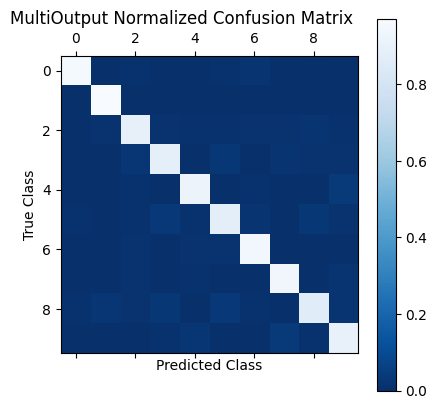

In [104]:
plt.matshow(cm_mlt_op_norm, cmap = plt.cm.Blues_r)
plt.colorbar()
plt.title("MultiOutput Normalized Confusion Matrix ",loc = "right" )
plt.xlabel("Predicted Class")
plt.ylabel("True Class");

### For is_even

In [106]:
even_true = y_multioutput_test[:,1]
even_pred = y_multioutput_pred[:, 1]

In [109]:
print("Classification Report for MultiOutput is : \n",classification_report(even_true, even_pred))

Classification Report for MultiOutput is : 
               precision    recall  f1-score   support

           0       0.90      0.91      0.90      7229
           1       0.90      0.89      0.90      6771

    accuracy                           0.90     14000
   macro avg       0.90      0.90      0.90     14000
weighted avg       0.90      0.90      0.90     14000



In [111]:
even_cm = confusion_matrix(even_pred, even_true)
even_cm

array([[6551,  723],
       [ 678, 6048]], dtype=int64)

### Error Correaltion Check

In [112]:
digit_error = (digit_true != digit_pred)
even_error = (even_true != even_pred)
np.mean(digit_error & even_error)

0.03142857142857143

---
##  Multiclass Classification — Error Analysis
---
### Interpretation:

**Low value → errors are independent**

**High value → outputs interfere**

----

#### Multioutput error analysis is done per output using task-appropriate metrics; there is no joint accuracy.

Although the multiclass classifier achieves strong overall accuracy, the confusion matrix reveals
systematic misclassifications between specific digit pairs. Digits with visually similar stroke
patterns are more frequently confused, indicating that most errors arise from ambiguous handwritten
samples rather than random noise.

The normalized confusion matrix shows that some digits consistently exhibit lower recall than others,
suggesting uneven class difficulty. These errors are largely symmetric, implying that the model
struggles to distinguish between certain digit shapes rather than favoring a particular class.

This analysis highlights a key limitation of the multiclass formulation: the model is forced to make a
single hard decision even when multiple digit properties could be inferred independently. This
motivates exploring a multilabel formulation to predict digit properties separately.

---
